This notebook is for re-computing a subset of the master list that is in the NSA footprint, including K-corrections

In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import tempfile

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

from collections import Counter, OrderedDict

import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table, cosmology, constants as cnst
from astropy.visualization import hist as ahist

#SAGA imports
import hosts
import targeting
import kcorrect
from masterlist import masterlist as masterlist_module

In [3]:
%matplotlib inline
from matplotlib import style, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

# Preliminaries/definitions 

In [4]:
# bands used here ugrizJHK
# these are Rx = Ax/E(B-V) for R_V~=3.1

# SFD 98 values 
sfd_Rx = np.array([5.155,3.793,2.751,2.086,1.479,0.902,0.576,0.367])

# Schlafly & FInkbeiner 2011
sandf_Rx = np.array([4.239, 3.303, 2.285, 1.698, 1.263, 0.709, 0.449,0.302])

#from Yuan+ 13 : https://arxiv.org/abs/1301.1427v1
yuan_FN_Rx = np.array([4.89, 7.24])

In [5]:
A_MAG = 2.5/np.log(10)
def flux_ivar_to_mag(flux, ivar):
    mag = -2.5 * np.log10(flux)
    
    sd = ivar**-0.5
    mag_err = A_MAG * sd/flux
    
    return mag, mag_err

def mag_err_to_maggies(mag, mag_err):
    flux = 10**(mag/-2.5)
    flux_err_sd = mag_err * flux/A_MAG
    
    return flux, flux_err_sd**-2

##  Set up the K-correction machinery

In [6]:
kcorrect.load_templates()

def load_filters_by_name(bandnmfns, band_shift=0.0, verbose=False):
    with tempfile.NamedTemporaryFile() as ntf:
        ntf.write('KCORRECT_DIR\n')
        for bandnm in bandnmfns:
            fn = 'data/filters/{}'.format(bandnm)
            truefn = os.path.join(os.environ['KCORRECT_DIR'], fn)
            if not os.path.isfile(truefn):
                raise IOError('Filter file {} does not exist'.format(truefn))
            ntf.write(fn)
            ntf.write('\n')

        ntf.seek(0)
        if verbose:
            !cat $ntf.name
        kcorrect.load_filters(ntf.name, band_shift)

In [7]:
# used way below when actually computing k-corrections
FNugrizJHK_filters = ['galex_{}UV.par'.format(bandnm) for bandnm in 'FN']
FNugrizJHK_filters.extend(['sdss_{}0.par'.format(bandnm) for bandnm in 'ugriz'])
FNugrizJHK_filters.extend(['twomass_{}.par'.format(bandnm) for bandnm in ('J','H','Ks')])

In [8]:
def do_kcorrs(maggies, maggie_ivars, redshifts, filternames, band_shift_to=None):
    
    if filternames is not None:
        load_filters_by_name(filternames)
    
    if np.isscalar(redshifts):
        maggies = [maggies]
        maggie_ivars = [maggie_ivars]
        redshifts = [redshifts]
    if len(maggies) != len(maggie_ivars) or len(maggies) != len(redshifts):
        raise ValueError('maggies, maggie_ivars, and redshifts must all be matching length')
        
    coeffs = []
    rms = []
    rm0s = []
    
    for m, mi, z in zip(maggies, maggie_ivars, redshifts):
        coeffs.append(kcorrect.fit_nonneg(z, m, mi))
        rms.append(kcorrect.reconstruct_maggies(coeffs[-1]))
        
    if band_shift_to:
        load_filters_by_name(filternames, band_shift=band_shift_to)
        
    for coeff in coeffs:
        rm0s.append(kcorrect.reconstruct_maggies(coeff, redshift=0.))
        
    flux_kcorr = np.array(rms)[:, 1:]/np.array(rm0s)[:, 1:]
    mag_kcorr = -2.5*np.log10(flux_kcorr)
    return mag_kcorr, flux_kcorr

# Load masterlist and associated bits 

In [9]:
# this is for the masterlist from dropbox

# masterlist = table.Table.read('SAGADropbox/hosts/masterlist.csv', data_start=2)

# units = table.Table.read('SAGADropbox/hosts/masterlist.csv', data_end=2)
# for c in masterlist.colnames:
#     masterlist[c].unit = units[c][0].replace('#', '').replace('degrees', 'degree')

    
# masterlist

In [10]:
# uncomment this to load the "old" masterlist but make it look like the new one
masterlist = table.Table.read('masterlist/masterlist.csv', data_start=2)

units = table.Table.read('SAGADropbox/hosts/masterlist.csv', data_end=2)
for c in masterlist.colnames:
    if c in units.colnames:
        masterlist[c].unit = units[c][0].replace('#', '').replace('degrees', 'degree')
    else:
        del masterlist[c]
        
vhe_col = np.zeros_like(masterlist['vhelio'])
vhe_col.name = 'vhelio_err'
vhe_col.mask[:] = True
masterlist.add_column(vhe_col, masterlist.colnames.index('vhelio')+1)
masterlist

RA,Dec,PGC#,NSAID,othername,vhelio,vhelio_err,distance,r,i,z,I,K
deg,deg,,,string,km / s,km / s,Mpc,mag,mag,mag,mag,mag
float64,float64,int64,int64,str28,float64,float64,float64,float64,float64,float64,float64,float64
155.411800699,0.900255164384,--,464,--,700.781494141,--,12.9443502426,17.840913133,17.8592532438,17.9387725156,--,--
168.044331058,-0.979240347779,--,858,--,3976.91381836,--,62.2746047974,16.1102515712,16.0128928676,15.9054061427,--,13.32
167.573676285,-0.263963231217,--,878,--,3859.34301758,--,59.6892051697,18.3784213542,18.2978530406,18.1733050822,--,13.476
176.53220815,-0.457941560233,--,1189,--,3915.22314453,--,61.1299934387,17.6042816183,17.49819298,17.3905078909,--,13.562
175.827885017,0.212515965092,--,1212,--,63.835975647,--,2.15789842606,13.2552742387,13.1355556871,12.8214039231,--,--
185.86139022,-0.411951305215,--,1398,--,-35.2995071411,--,1.56168830395,16.7008180487,16.6945266592,16.7462901938,--,--
188.117462781,0.388846619893,--,1498,--,1514.17663574,--,23.8685760498,13.1889792025,12.9452524721,12.936596924,--,--
189.18629219,0.563405647876,--,1539,--,3739.31225586,--,60.0032844543,18.3082506816,18.2208168666,18.1446879069,--,--


In [11]:
nsa = table.Table(hosts.get_nsa())

In [12]:
#for NSA we have this round-about but simple way to get E(B-V) so we can get the S&F extinction
# See end of the notebook for proof that it works

nsa['E(B-V)'] = np.mean(np.array(nsa['EXTINCTION'])[:,-5:]/sfd_Rx[:5], axis=1)

In [13]:
twomassxsc = masterlist_module.load_2mass_xsc('masterlist/2mass_xsc_irsa.tab')
twomassxsc

ra,dec,r_k20fe,j_m_k20fe,j_msig_k20fe,j_flg_k20fe,h_m_k20fe,h_msig_k20fe,h_flg_k20fe,k_m_k20fe,k_msig_k20fe,k_flg_k20fe,k_ba,k_phi,j_m_ext,j_msig_ext,h_m_ext,h_msig_ext,k_m_ext,k_msig_ext,cc_flg
float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,str1
161.902771,-1.185182,5.0,15.124,0.109,0,14.316,0.135,0,13.875,0.156,0,1.0,90,14.97,0.184,13.99,0.191,13.612,0.232,0
176.174164,24.901585,5.0,15.508,0.102,0,14.799,0.129,0,14.446,0.16,0,1.0,90,15.294,0.148,14.514,0.175,14.169,0.221,0
122.197197,-10.182686,5.0,15.573,0.138,0,--,--,--,14.198,0.19,0,1.0,90,15.298,0.197,14.979,0.0,13.986,0.291,0
67.092613,-39.653427,11.4,12.963,0.036,0,12.239,0.041,0,11.907,0.073,0,0.6,-40,12.775,0.041,12.136,0.047,11.844,0.079,0
58.178047,-48.642609,6.3,14.377,0.067,3,13.58,0.072,3,12.98,0.079,3,0.9,25,14.0,0.082,13.274,0.099,12.856,0.117,0
321.14444,-47.238235,6.4,14.754,0.095,0,13.984,0.112,0,13.49,0.105,0,1.0,90,14.476,0.132,13.606,0.149,13.304,0.168,0
73.605751,-22.839722,8.4,15.203,0.126,0,14.523,0.145,0,13.616,0.127,0,0.5,-55,15.014,0.189,14.385,0.23,13.241,0.167,0
163.984375,51.758099,5.0,15.346,0.096,0,14.75,0.153,0,14.043,0.118,0,1.0,90,15.114,0.14,14.727,0.278,13.788,0.172,0
312.112518,-65.092072,8.5,15.003,0.091,1,14.277,0.108,3,13.707,0.111,3,0.4,-35,14.922,0.164,14.077,0.162,13.261,0.133,0


# Build the sub-master list and add in the relevant photometry 

In [14]:
colstokeep = ['RA', 'Dec', 'NSAID', 'othername', 'vhelio', 'vhelio_err', 'distance']
submaster0 = masterlist[~masterlist['NSAID'].mask][colstokeep]
submaster0

RA,Dec,NSAID,othername,vhelio,vhelio_err,distance
deg,deg,,string,km / s,km / s,Mpc
float64,float64,int64,str28,float64,float64,float64
155.411800699,0.900255164384,464,--,700.781494141,--,12.9443502426
168.044331058,-0.979240347779,858,--,3976.91381836,--,62.2746047974
167.573676285,-0.263963231217,878,--,3859.34301758,--,59.6892051697
176.53220815,-0.457941560233,1189,--,3915.22314453,--,61.1299934387
175.827885017,0.212515965092,1212,--,63.835975647,--,2.15789842606
185.86139022,-0.411951305215,1398,--,-35.2995071411,--,1.56168830395
188.117462781,0.388846619893,1498,--,1514.17663574,--,23.8685760498
189.18629219,0.563405647876,1539,--,3739.31225586,--,60.0032844543


In [15]:
#integrate NSA photometry

nsatoadd = nsa[('NSAID', 'E(B-V)')]
for i, band in enumerate('FNugriz'):
    nsatoadd[band+'_flux'] = maggies = nsa['SERSICFLUX'][:, i]/1e9
    nsatoadd[band+'_flux_ivar'] = ivar = nsa['SERSICFLUX_IVAR'][:, i]*1e18
    nsatoadd[band+'_flux'].unit = nsatoadd[band+'_flux_ivar'].unit = 'maggie'
    nsatoadd['NSA_kcorrect_' + band] = nsa['KCORRECT'][:, i]
    
    mag, mag_err = flux_ivar_to_mag(maggies, ivar)
    nsatoadd[band] = mag
    nsatoadd[band+'_err'] = mag_err
    
    
submaster1 = table.join(submaster0, nsatoadd, 'NSAID')
submaster1

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in true_divide


RA,Dec,NSAID,othername,vhelio,vhelio_err,distance,E(B-V),F_flux,F_flux_ivar,NSA_kcorrect_F,F,F_err,N_flux,N_flux_ivar,NSA_kcorrect_N,N,N_err,u_flux,u_flux_ivar,NSA_kcorrect_u,u,u_err,g_flux,g_flux_ivar,NSA_kcorrect_g,g,g_err,r_flux,r_flux_ivar,NSA_kcorrect_r,r,r_err,i_flux,i_flux_ivar,NSA_kcorrect_i,i,i_err,z_flux,z_flux_ivar,NSA_kcorrect_z,z,z_err
deg,deg,,string,km / s,km / s,Mpc,,maggie,maggie,,,,maggie,maggie,,,,maggie,maggie,,,,maggie,maggie,,,,maggie,maggie,,,,maggie,maggie,,,,maggie,maggie,,,
float64,float64,int64,str28,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
147.176446949,-0.354030416643,2,PGC1145436,1883.54833984,--,29.5901851654,0.0877028543881,9.7141e-09,3.07981e+18,0.000293507,20.0315,0.0636883,1.46447e-08,5.0814e+18,0.00322668,19.5858,0.032889,6.418e-08,3.19377e+17,0.0204647,17.9815,0.0299346,1.8737e-07,1.05967e+18,0.0043341,16.8183,0.00562909,3.02488e-07,4.82708e+17,0.00354034,16.2982,0.00516624,3.81385e-07,2.2234e+17,-0.000801596,16.0466,0.00603743,4.27964e-07,2.09357e+16,-0.00130408,15.9215,0.0175337
146.193241319,-0.689391394961,6,PGC1137164,1223.25012207,--,20.8565635681,0.0636514724703,3.93608e-08,8.62594e+17,-0.00221279,18.5123,0.0297,5.12427e-08,1.63739e+18,0.000898001,18.2259,0.0165583,1.55028e-07,1.08292e+17,0.0107687,17.024,0.0212822,4.00652e-07,1.09318e+16,0.00074526,15.9931,0.0259186,5.23994e-07,1.52134e+17,0.00131525,15.7017,0.00531233,6.24827e-07,7.01852e+16,-0.00178339,15.5106,0.00655906,6.81238e-07,6.39879e+15,-0.00187499,15.4168,0.019924
146.007801384,-0.64225922322,7,PGC027864,1431.89880371,--,23.6615562439,0.0630527284911,2.73263e-07,1.05155e+17,-0.00686175,16.4085,0.0122526,3.24842e-07,2.15838e+17,-0.00560074,16.2208,0.00719428,5.74697e-07,1.29828e+17,0.00241028,15.6014,0.00524326,1.08117e-06,2.38812e+17,-0.00601297,14.9153,0.00205496,9.93737e-07,2.26204e+17,0.00194088,15.0068,0.00229722,5.41217e-07,4.53568e+17,-0.0066505,15.6666,0.00297873,6.29883e-07,2.47482e+16,-0.00400293,15.5019,0.010957
146.619063376,-0.434345458168,9,PGC1143397,1809.7376709,--,28.651517868,0.106928527026,2.45369e-08,1.25217e+18,-0.000843304,19.0254,0.0395432,4.06546e-08,2.79773e+18,0.00329662,18.4772,0.0159666,1.48096e-07,1.96303e+17,0.01706,17.0736,0.0165469,4.35641e-07,5.22774e+17,0.00292183,15.9022,0.00344698,6.74417e-07,2.94652e+17,0.00251721,15.4277,0.0029658,8.3668e-07,2.40224e+17,-0.00142272,15.1936,0.00264763,1.00119e-06,1.07042e+16,-0.00189742,14.9987,0.0104817
145.320962664,0.771102651396,30,PGC1175027,1975.47937012,--,30.8803977966,0.114671165201,5.43166e-09,9.08762e+18,-0.000314172,20.6627,0.0663081,7.6787e-09,2.25418e+19,0.00289188,20.2868,0.0297812,3.19299e-08,1.44307e+18,0.0207045,18.7395,0.0283063,9.06743e-08,3.4354e+18,0.00224096,17.6063,0.00646028,1.36714e-07,1.78682e+18,0.0032321,17.1605,0.00594115,1.65712e-07,8.25998e+17,-0.00267745,16.9516,0.00720908,1.94639e-07,1.05222e+17,-0.00265435,16.7769,0.0171965
145.513690377,0.336451585096,32,NGC_2967,1912.34655762,--,30.0373516083,0.0995307787189,5.82052e-07,6.12737e+16,-9.65589e-05,15.5876,0.00753573,1.19249e-06,5.91133e+16,0.0085996,14.8089,0.00374479,4.89467e-06,8.50241e+15,0.0127802,13.2757,0.00240563,1.59454e-05,2.10607e+16,0.00835508,11.9934,0.000469193,2.89876e-05,7.44139e+15,0.00219524,11.3445,0.000434196,3.97876e-05,3.8533e+15,0.00214499,11.0006,0.000439603,5.0046e-05,3.33341e+14,2.48502e-05,10.7516,0.00118826
146.265781145,1.23041252815,43,SDSSJ094503.80+011349.5,1905.23034668,--,29.9755420685,0.160540565768,9.76453e-10,1.2036e+19,0.0230798,22.5259,0.320503,1.36736e-09,1.52237e+19,0.00880183,22.1603,0.203508,1.61847e-08,1.63852e+18,0.0262728,19.4772,0.0524074,4.98293e-08,4.79183e+18,0.00219162,18.2563,0.0099538,7.59066e-08,2.31665e+18,0.00370597,17.7993,0.00939755,9.3876e-08,1.81

# Now add in the 2MASS JHK 

Requires X-matching NSA to 2MASS XSC

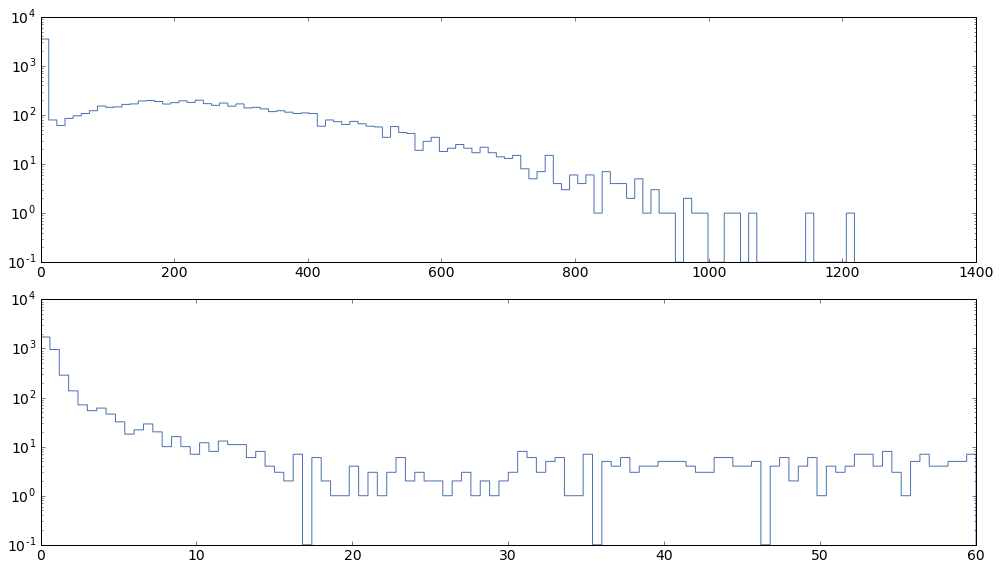

In [16]:
scsubm = SkyCoord(submaster1['RA'], submaster1['Dec'])
sc2mass = SkyCoord(twomassxsc['ra'], twomassxsc['dec'], unit=u.deg)

idx, d2d, _ = scsubm.match_to_catalog_sky(sc2mass)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.hist(d2d.arcsec, histtype='step',bins=100, log=True)
ax2.hist(d2d.arcsec, histtype='step',bins=100, range=(0,60), log=True)

fig.tight_layout()

Why are there so many NSA objects not in 2MASS? For now we'll just accept these but keep around the distance to possibly mask later

In [17]:
submaster2 = submaster1.copy()
submaster2['dist_2MASS_NSA'] = d2d.to(u.arcsec)

In [18]:
idx2mass = twomassxsc[idx]

for band in 'jhk':
    twomass_col = '{}_m_ext'.format(band)
    twomass_err_col = '{}_msig_ext'.format(band)
    
    submaster2[band.upper()] = mag = idx2mass[twomass_col]
    submaster2[band.upper()+"_err"] = mag_err = idx2mass[twomass_err_col]
    
    flux, flux_ivar = mag_err_to_maggies(mag, mag_err)
    
    submaster2[band.upper() + '_flux'] = flux
    submaster2[band.upper() + '_flux_ivar'] = flux_ivar

In [19]:
# this is the "correction" one for use with extinction and kcorrecting
submaster3 = submaster2.copy()

In [20]:
submaster3['othername'].fill_value = ''
submaster3['othername'] = submaster3['othername'].filled()

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


# And compute extinction for all the bands 

In [21]:
for i, bandnm in enumerate('FNugrizJHK'):
    if bandnm in 'FN':
        submaster3['A_'+bandnm] = Ax = submaster3['E(B-V)']*yuan_FN_Rx[i]
    else:
        submaster3['A_'+bandnm] = Ax = submaster3['E(B-V)']*sandf_Rx[i-2]
    
    # this is X in $F_intrinsic = F X$ , that's why the - is missing from 2.5
    submaster3['A_'+bandnm+'_flux'] = 10**(Ax/2.5) 

# Now compute the kcorrection

In [22]:
maggies = np.array([submaster3[bandnm+'_flux'] for bandnm in 'FNugrizJHK']).T
ivars = np.array([submaster3[bandnm+'_flux_ivar'] for bandnm in 'FNugrizJHK']).T
zs = (u.Quantity(submaster3['vhelio'])/cnst.c).decompose()

mag_kcorrs, flux_kcorrs = do_kcorrs(maggies, ivars, zs, FNugrizJHK_filters)

for i, bandnm in enumerate('FNugrizJHK'):
    submaster3['kcorr_' + bandnm] = mag_kcorrs[:, i]

# Now choose the columns for the final submaster

In [23]:
for bandnm in 'ugrizJHK':
    extinction = submaster3['A_'+bandnm]
    kcorr = submaster3['kcorr_'+bandnm]
    distmod = Distance(submaster3['distance']).distmod.value
    submaster3['M_' + bandnm] = submaster3[bandnm] - extinction - kcorr - distmod 

In [24]:
infocols = ['RA', 'Dec', 'NSAID', 'othername', 
            'vhelio', 'vhelio_err',  'distance', 'dist_2MASS_NSA']
magcols = []
for bandnm in 'ugrizJHK':
    magcols.append(bandnm)
    magcols.append(bandnm+'_err')
    magcols.append('A_'+bandnm)
    magcols.append('M_'+bandnm)
    
# reset the units
for colnm in magcols:
    submaster3[colnm].unit = 'mag'
    
submaster = submaster3[infocols + magcols]
submaster

RA,Dec,NSAID,othername,vhelio,vhelio_err,distance,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r,r_err,A_r,M_r,i,i_err,A_i,M_i,z,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K,K_err,A_K,M_K
deg,deg,,string,km / s,km / s,Mpc,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
float64,float64,int64,str28,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
147.176446949,-0.354030416643,2,PGC1145436,1883.54833984,--,29.5901851654,271.12659476,17.9815,0.0299346,0.371772399751,-14.7638945881,16.8183,0.00562909,0.289682528044,-15.8350120874,16.2982,0.00516624,0.200401022277,-16.2611153965,16.0466,0.00603743,0.148919446751,-16.4595905795,15.9215,0.0175337,0.110768705092,-16.5450393011,13.136,0.068,0.0621813237612,-19.2775345916,12.24,0.08,0.0393785816203,-20.1516117463,12.07,0.107,0.0264862620252,-20.2975449006
146.193241319,-0.689391394961,6,PGC1137164,1223.25012207,--,20.8565635681,259.723835062,17.024,0.0212822,0.269818591802,-14.8515948307,15.9931,0.0259186,0.21024081357,-15.8162365785,15.7017,0.00531233,0.145443614595,-16.041370377,15.5106,0.00655906,0.108080200255,-16.1936503422,15.4168,0.019924,0.08039180973,-16.2592447894,14.38,0.172,0.0451288939815,-17.258133278,13.483,0.195,0.0285795111392,-18.1393908729,12.679,0.152,0.019222744686,-18.9268949287
146.007801384,-0.64225922322,7,PGC027864,1431.89880371,--,23.6615562439,495.116208982,15.6014,0.00524326,0.267280516074,-16.540037589,14.9153,0.00205496,0.208263162206,-17.1585876025,15.0068,0.00229722,0.144075484602,-17.0093854463,15.6666,0.00297873,0.107063532978,-16.3051633557,15.5019,0.010957,0.0796355960842,-16.4448059026,14.154,0.104,0.0447043845002,-17.7555273975,13.642,0.161,0.0283106750925,-18.2535292188,13.33,0.215,0.0190419240043,-18.5477950063
146.619063376,-0.434345458168,9,PGC1143397,1809.7376709,--,28.651517868,380.956537656,17.0736,0.0165469,0.453270026063,-15.6815395625,15.9022,0.00344698,0.353184924767,-16.7432785712,15.4277,0.0029658,0.244331684254,-17.1049758007,15.1936,0.00264763,0.18156463889,-17.2747037584,14.9987,0.0104817,0.135050729634,-17.4217302217,14.513,0.127,0.0758123256614,-17.8441785006,13.578,0.123,0.0480109086346,-18.7522167393,13.343,0.184,0.0322924151618,-18.9608643805
145.320962664,0.771102651396,30,PGC1175027,1975.47937012,--,30.8803977966,297.466447178,18.7395,0.0283063,0.486091069287,-14.2157632918,17.6063,0.00646028,0.378758858659,-15.2271029441,17.1605,0.00594115,0.262023612484,-15.5532955974,16.9516,0.00720908,0.194711638511,-15.6918434344,16.7769,0.0171965,0.144829681649,-15.8155746228,14.788,0.207,0.0813018561274,-17.7367197733,14.125,0.214,0.0514873531752,-18.3711443445,13.37,0.245,0.0346306918907,-19.0976487226
145.513690377,0.336451585096,32,NGC_2967,1912.34655762,--,30.0373516083,0.71028220674,13.2757,0.00240563,0.421910970989,-19.549132869,11.9934,0.000469193,0.328750162108,-20.7350530517,11.3445,0.000434196,0.227427829373,-21.2755714191,11.0006,0.000439603,0.169003262265,-21.5609463662,10.7516,0.00118826,0.125707373522,-21.7649364673,9.765,0.019,0.0705673221117,-22.69126327,9.104,0.018,0.0446893196448,-23.3274371912,8.883,0.034,0.0300582951731,-23.5218249121
146.265781145,1.23041252815,43,SDSSJ094503.80+011349.5,1905.23034668,--,29.9755420685,364.541201352,19.4772,0.0524074,0.680531458291,-13.6131102411,18.2563,0.0099538,0.530265488732,-14.6650543961,17.7993,0.00939755,0.36683519278,-14.955686629,17.5686,0.00859179,0.272597880674,-15.0884816437,17.3586,0.804604,0.202762734565,-15.2278201763,14.553,0.132,0.11382326113,-17.9400700732,14.17,0.182,0.0720827140299,-18.2826204221,13.265,0.161,0.048483250862,-19.15247361
146.045441016,0.179766406149,48,PGC1159096,3334.94750977,--,50.9555702209,70.7798744736,18.0851,0.01850

# And write it all out 

In [62]:
fill_values = [('--', '-1')]
submaster.write('masterlist/submaster.ecsv', format='ascii.ecsv', fill_values=fill_values)
submaster3.write('masterlist/submaster_all.ecsv', format='ascii.ecsv', fill_values=fill_values)

In [63]:
!gzip -f masterlist/submaster.ecsv
!gzip -f masterlist/submaster_all.ecsv

In [64]:
!cp masterlist/submaster.ecsv.gz SAGADropbox/hosts/
!cp masterlist/submaster_all.ecsv.gz SAGADropbox/hosts/

In [67]:
table = table.Table.read('masterlist/submaster.ecsv.gz', format='ascii.ecsv')

# Appendix/consistency checks

## Is the difference between vdist and z significant enough to worry about? 

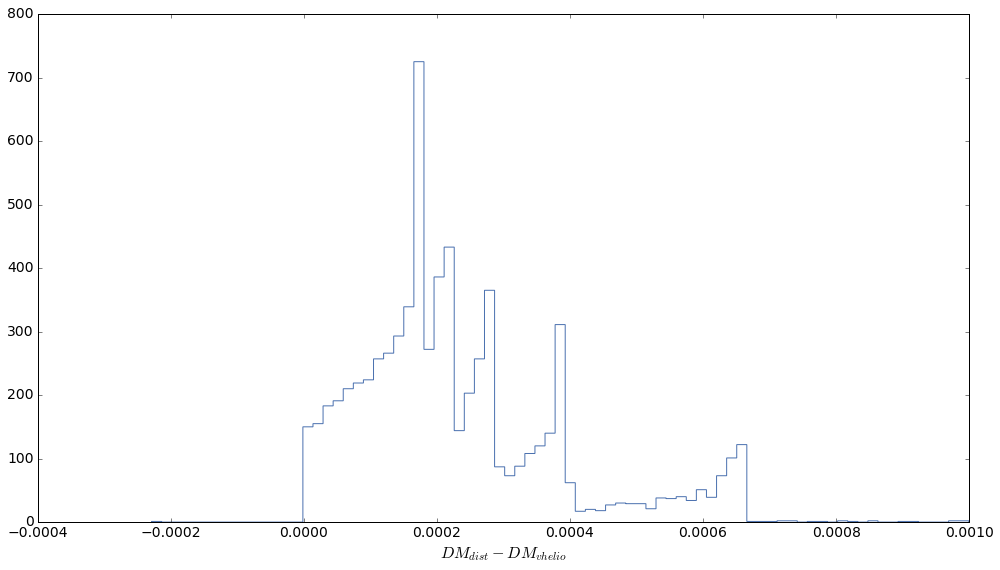

In [113]:
z = (u.Quantity(submaster['vhelio'])/cnst.c).decompose()
dmz = Distance(cosmology.WMAP9.luminosity_distance(z), allow_negative=True).distmod
dmd = Distance(submaster['distance']).distmod
dd = dmd - dmz

ahist(dd[np.isfinite(dd)], bins='knuth', histtype='step', range=(-.0003, .001))
plt.xlabel('$DM_{dist} - DM_{vhelio}$')
plt.tight_layout()

Looks like totally-ignorable

##  Checking assumptions about extintion in NSA

Is it true that the sfd_Rx values above give the same E(B-V) values for all 5 bands?  If yes, it means Blanton got them straight from the SFD paper

In [131]:
np.array(nsa['EXTINCTION'])[:,-5:]/sfd_Rx[:5]

array([[ 0.05472223,  0.05472223,  0.05472223,  0.05472223,  0.05472223],
       [ 0.0521579 ,  0.05215789,  0.05215789,  0.05215789,  0.05215789],
       [ 0.08770286,  0.08770285,  0.08770285,  0.08770286,  0.08770285],
       ..., 
       [ 0.05120614,  0.05120613,  0.05120613,  0.05120613,  0.05120613],
       [ 0.06441259,  0.06441259,  0.06441258,  0.06441258,  0.06441259],
       [ 0.03289034,  0.03289033,  0.03289033,  0.03289033,  0.03289033]])

## Some consistency checks of kcorrections w/ what's already in NSA

In [21]:
maggies = np.array([submaster3[bandnm+'_flux'] for bandnm in 'FNugriz']).T
ivars = np.array([submaster3[bandnm+'_flux_ivar'] for bandnm in 'FNugriz']).T
zs = (u.Quantity(submaster3['vhelio'])/cnst.c).decompose()

mag_kcorrs_sdss, flux_kcorrs_sdss = do_kcorrs(maggies, ivars, zs, FNugrizJHK_filters[:7])

In [22]:
maggies = np.array([submaster3[bandnm+'_flux'] for bandnm in 'JHK']).T
ivars = np.array([submaster3[bandnm+'_flux_ivar'] for bandnm in 'JHK']).T
zs = (u.Quantity(submaster3['vhelio'])/cnst.c).decompose()

mag_kcorrs_2mass, flux_kcorrs_2mass = do_kcorrs(maggies, ivars, zs, FNugrizJHK_filters[-3:])

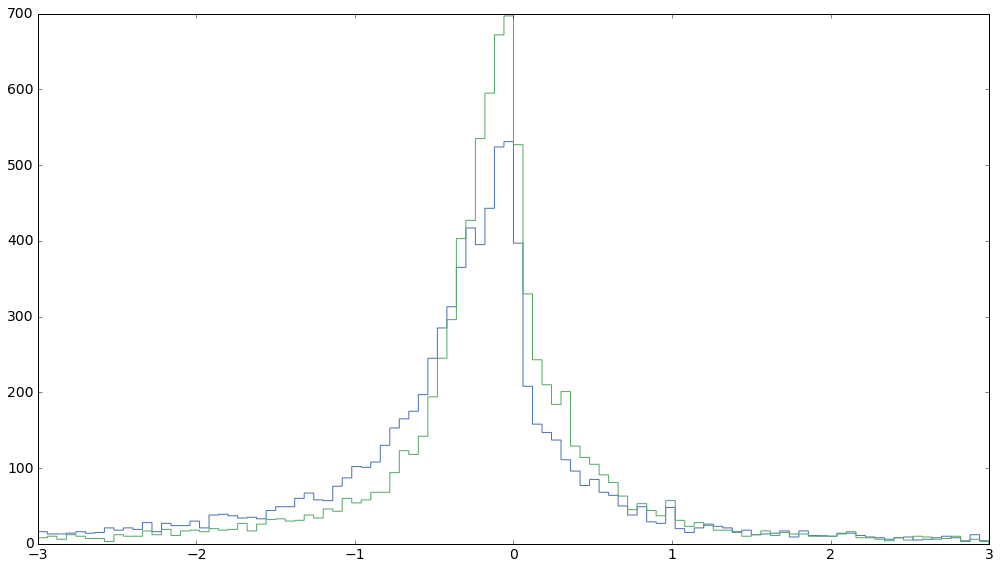

In [28]:
plt.hist((submaster3['NSA_kcorrect_r'] - mag_kcorrs[:, 4])/submaster3['NSA_kcorrect_r'], 
         bins=100, range=(-3,3), histtype='step')
plt.hist((submaster3['NSA_kcorrect_r'] - mag_kcorrs_sdss[:, 4])/submaster3['NSA_kcorrect_r'], 
         bins=100, range=(-3,3), histtype='step')
plt.tight_layout()

Looks like yes, so that's a consistent way to get E(B-V)

# Compare "old" and "new" masterlists 

In [33]:
omaster = table.Table.read('masterlist/masterlist.csv')
nmaster = table.Table.read('SAGADropbox/hosts/masterlist.csv', data_start=2)

In [34]:
omaster

RA,Dec,PGC#,NSAID,othername,vhelio,distance,r,i,z,I,K,K_err
float64,float64,int64,int64,str28,float64,float64,float64,float64,float64,float64,float64,float64
148.335342599,0.62856766514,--,112,--,3934.57617188,61.5896568298,17.6233010978,17.3994298667,17.3146577568,--,13.702,0.213
155.411800699,0.900255164384,--,464,--,700.781494141,12.9443502426,17.840913133,17.8592532438,17.9387725156,--,--,--
168.044331058,-0.979240347779,--,858,--,3976.91381836,62.2746047974,16.1102515712,16.0128928676,15.9054061427,--,13.32,0.184
167.573676285,-0.263963231217,--,878,--,3859.34301758,59.6892051697,18.3784213542,18.2978530406,18.1733050822,--,13.476,0.21
176.53220815,-0.457941560233,--,1189,--,3915.22314453,61.1299934387,17.6042816183,17.49819298,17.3905078909,--,13.562,0.198
175.827885017,0.212515965092,--,1212,--,63.835975647,2.15789842606,13.2552742387,13.1355556871,12.8214039231,--,--,--
185.86139022,-0.411951305215,--,1398,--,-35.2995071411,1.56168830395,16.7008180487,16.6945266592,16.7462901938,--,--,--
188.117462781,0.388846619893,--,1498,--,1514.17663574,23.8685760498,13.1889792025,12.9452524721,12.936596924,--,--,--
189.18629219,0.563405647876,--,1539,--,3739.31225586,60.0032844543,18.3082506816,18.2208168666,18.1446879069,--,--,--


In [35]:
nmaster

RA,Dec,PGC#,NSAID,othername,vhelio,vhelio_err,distance,r,i,z,I,K
float64,float64,int64,int64,str28,float64,float64,float64,float64,float64,float64,float64,float64
155.411800699,0.900255164384,--,464,--,897.302368164,190.000305176,12.9778122978,17.8465192987,17.8648594095,17.9443786814,--,--
175.827885017,0.212515965092,--,1212,--,149.585525513,95.0001525879,2.16116345011,13.2585573178,13.1388387662,12.8246870023,--,--
185.86139022,-0.411951305215,--,1398,--,108.256233215,70.0001144409,1.56371211242,16.7036302611,16.6973388716,16.7491024061,--,--
170.835578635,-3.13086875479,--,2996,--,2707.15625,160.000244141,39.3325045658,17.4986403253,17.3694737222,17.1953413751,--,--
179.301669033,-2.68650062571,--,3272,--,1536.73803711,142.500213623,22.2595972489,17.4616379866,17.5221982131,17.5233359465,--,--
178.369363427,-3.22968533309,--,3276,--,1586.27331543,142.500213623,22.9809618134,17.0503131048,16.9707919256,16.9346038,--,--
190.414321924,-1.44519645427,--,3526,--,146.170669556,87.5001296997,2.11179869823,7.73738497991,6.79136294621,7.93538874883,--,--
191.530258224,-3.26911585606,--,3537,--,1156.52880859,172.500274658,16.7390133251,17.396934302,17.1693904711,17.0419090105,--,13.254
190.497254971,-3.66736412411,--,3549,--,2826.93212891,147.500244141,41.0831285087,18.8093615845,19.398808606,19.3847695664,--,--


In [110]:
omaster_nsa = omaster[~omaster['NSAID'].mask]
nmaster_nsa = nmaster[~nmaster['NSAID'].mask]

merged = table.join(omaster_nsa, nmaster_nsa, ['NSAID'], 'left')
sub_merged = merged['NSAID', 'vhelio_1', 'vhelio_2', 'distance_1', 'distance_2']
sub_merged

NSAID,vhelio_1,vhelio_2,distance_1,distance_2
int64,float64,float64,float64,float64
2,1883.54833984,2051.19165039,29.5901851654,29.7514014598
6,1223.25012207,1445.77697754,20.8565635681,20.9358094095
7,1431.89880371,1640.21911621,23.6615562439,23.7665552411
9,1809.7376709,1986.12316895,28.651517868,28.8038324065
30,1975.47937012,2140.62915039,30.8803977966,31.0538478259
32,1912.34655762,2082.18920898,30.0373516083,30.0
43,1905.23034668,2077.90454102,29.9755420685,30.1404117443
48,3334.94750977,3532.24023438,50.9555702209,51.4263961604
59,1775.37475586,1958.51794434,28.253288269,36.5


In [111]:
sub_merged[sub_merged['NSAID']==129461]

NSAID,vhelio_1,vhelio_2,distance_1,distance_2
int64,float64,float64,float64,float64
129461,2379.00366211,2379.42602539,34.3252449036,24.0


In [112]:
sub_merged[sub_merged['NSAID']==2]

NSAID,vhelio_1,vhelio_2,distance_1,distance_2
int64,float64,float64,float64,float64
2,1883.54833984,2051.19165039,29.5901851654,29.7514014598


Wha? Why are only *some* of them different??

# Understanding the Submaster/masterlist missing-K problem

This section is getting at why the submaster list seems to have more objects with K-band (2MASS) detections than the masterlist.  Or more broadly, why there aren't K-band detections for *all* the targets, given that 2MASS is supposed to be complete for $M_K<-19.6$ and $cz < 3000$ km/s

First we take a look at two sets of objects in the 2MASS and SDSS image browser: those from the sub-master that *have* a 2MASS match, and those that do not.

In [25]:
def get_2mass_url(row, show_in_browser=True):
    twomass_url_templ = 'http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS={0[RA]:.6f}d+{0[Dec]:.6f}d&subsz=&date=&scan=&coadd=&key=&band=K'
    url = twomass_url_templ.format(row)
    
    if show_in_browser:
        import webbrowser
        webbrowser.open(url)
        
    return url

def get_sdss_url(row, show_in_browser=True):
    sdss_url_templ = 'http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra={0[RA]:.6f}&dec={0[Dec]:.6f}'
    url = sdss_url_templ.format(row)
    
    if show_in_browser:
        import webbrowser
        webbrowser.open(url)
        
    return url

In [38]:
kvmsk = (submaster['M_K']<-19.6)&(submaster['vhelio']<3000)

goodmatches = submaster[kvmsk&(submaster['dist_2MASS_NSA']<10*u.arcsec)]
badmatches = submaster[kvmsk&(submaster['dist_2MASS_NSA']>60*u.arcsec)]

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


In [36]:
goodsubset = goodmatches[np.random.permutation(len(goodmatches))[:3]]
for row in goodsubset:
    print('NSAID', row['NSAID'], 'othername', row['othername'])
    print('2MASS:', get_2mass_url(row))
    print('SDSS:', get_sdss_url(row))
    print('')

NSAID 158036 othername NGC_3169
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=153.562643d+3.466152d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=153.562643&dec=3.466152

NSAID 133324 othername PGC012468
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=50.042228d+41.351128d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=50.042228&dec=41.351128

NSAID 76834 othername 09202038+6406106
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=140.084882d+64.103066d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=140.084882&dec=64.103066



As an aside... This last one (NSAID 76834/NGC 2805) is a fascinating-looking galaxy (apparently in the group Holmberg Holmberg 124)!  Is it ram-pressure stripping?  If so what's with the funky corner-like morphology? But I digress...

In [37]:
badsubset = badmatches[np.random.permutation(len(badmatches))[:3]]
for row in badsubset:
    print('NSAID', row['NSAID'], 'othername', row['othername'])
    print('2MASS:', get_2mass_url(row))
    print('SDSS:', get_sdss_url(row))
    print('')

NSAID 142657 othername PGC044474
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=194.650140d+1.707247d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=194.650140&dec=1.707247

NSAID 138996 othername PGC166109
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=168.498318d+11.329474d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=168.498318&dec=11.329474

NSAID 37364 othername PGC2592225
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=170.024503d+59.595984d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=170.024503&dec=59.595984



Examination of these two subsets makes it clear that they are *not* the same subsets of objects: the "no-match" objects are all notably fainter/lower SB than the matched ones.

So now lets check the subset that are bright in *r* in addition to being bright in K.

In [40]:
# 3.28 and 4.67 are K and r-band solar magnitudes, so here implicitly assuming the average galaxy has sun-like r-K color
solar_rmK = 4.67 - 3.28
rbrightmsk = (submaster['M_r'] - solar_rmK)<-19.6

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


Fraction > 30 arcsec 0.0746835443038
Fraction > 30 arcsec 0.291091593476


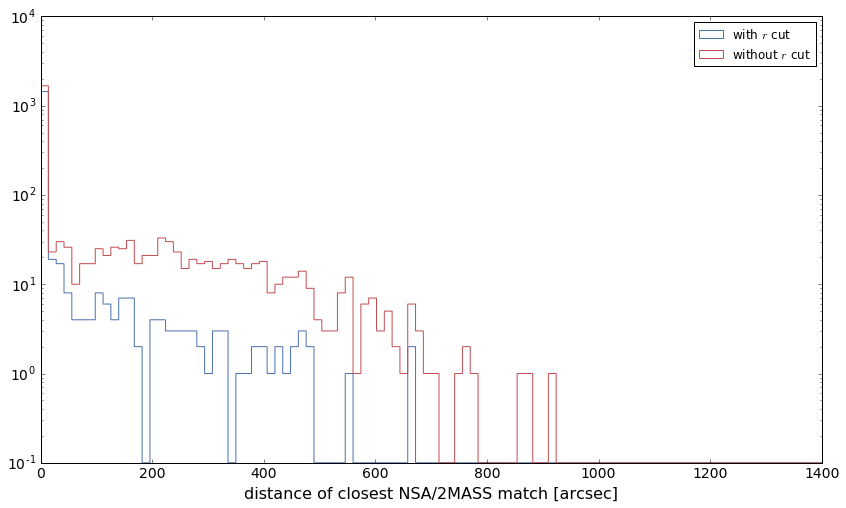

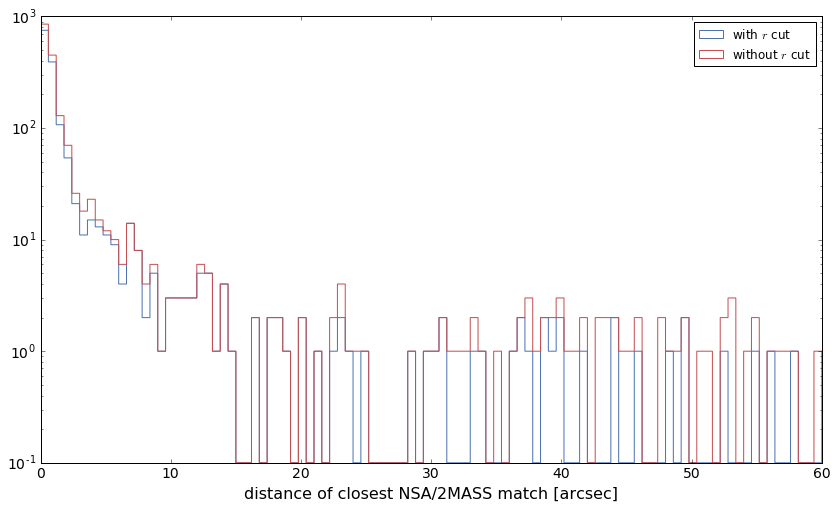

In [70]:
plt.figure()
_, b, _ = plt.hist(submaster[rbrightmsk&kvmsk]['dist_2MASS_NSA'], 
                   bins=100, range=(0,1400), log=True, 
                   histtype='step', label='with $r$ cut')
plt.hist(submaster[kvmsk]['dist_2MASS_NSA'],  bins=b, log=True, 
                   histtype='step', label='without $r$ cut', 
                   color=list(plt.rcParams['axes.prop_cycle'])[2]['color'])
plt.legend()
plt.xlabel('distance of closest NSA/2MASS match [arcsec]')

plt.figure()
_, b, _ = plt.hist(submaster[rbrightmsk&kvmsk]['dist_2MASS_NSA'], 
                   bins=100, range=(0,60), log=True, 
                   histtype='step', label='with $r$ cut')
plt.hist(submaster[kvmsk]['dist_2MASS_NSA'],  bins=b, log=True, 
                   histtype='step', label='without $r$ cut', 
                   color=list(plt.rcParams['axes.prop_cycle'])[2]['color'])
plt.legend()
plt.xlabel('distance of closest NSA/2MASS match [arcsec]')

print('Fraction > 30 arcsec', np.sum(submaster[rbrightmsk&kvmsk]['dist_2MASS_NSA']>30*u.arcsec)/np.sum(rbrightmsk&kvmsk))
print('Fraction > 30 arcsec', np.sum(submaster[kvmsk]['dist_2MASS_NSA']>30*u.arcsec)/np.sum(kvmsk))

So what are those remaining 7%?

In [76]:
boundaryobjs = submaster[(submaster['dist_2MASS_NSA']>30*u.arcsec)&rbrightmsk&kvmsk]
boundarysubset = boundaryobjs[np.random.permutation(len(boundaryobjs))[:5]]
for row in boundarysubset:
    print('NSAID', row['NSAID'], 'othername', row['othername'])
    print('2MASS:', get_2mass_url(row))
    print('SDSS:', get_sdss_url(row))
    print('')

NSAID 169804 othername UGC06717
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=176.191046d+9.212555d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=176.191046&dec=9.212555

NSAID 124893 othername 
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=114.278675d+65.610897d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=114.278675&dec=65.610897

NSAID 149474 othername PGC1077281
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=329.567842d+-3.058465d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss.org/dr13/en/tools/chart/navi.aspx?ra=329.567842&dec=-3.058465

NSAID 134208 othername PGC017304
2MASS: http://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_pos?type=at&ds=asky&POS=81.788625d+-6.119133d&subsz=&date=&scan=&coadd=&key=&band=K
SDSS: http://skyserver.sdss

All either artifacts due to nearby bright stars/shredding, or faint things close to the edge of detectability.

Conclusion: the reason why there are a large number of "missing" NSA/2MASS matches is that if there's not a K-band magnitude, our K-band magnitude cut did not remove them!  If we instead cut on r-band ~= to the expected K-band cut, "missing" objects go away.  So the alternative aproach we've taken of saying "if it has K *and* meets the cut, it's in the sample" is OK, because those that don't have a K-band magnitude are almost invariably faint (or a small fraction of artifacts).